# Tutorial 4
## MA course in Artificial Intelligence 2022/2023

In [ ]:
!rm -rf AI2020MA
!git clone https://github.com/UmbertoJr/AI2022MA.git

In [1]:
# Imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IO_manager.io_tsp import TSP_Instance_Creator
from solvers.TSP_solver import Solver_TSP
from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from solvers.constructive_algorithms import compute_length
from solvers.local_search import TwoOpt

# If you are not running from your local, add the prefix AI2021MA (comment the previous lines and use instead the following lines)
# from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# from AI2022MA.solvers.local_search import TwoOpt
# from AI2022MA.solvers.TSP_solver import Solver_TSP
# from AI2022MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from AI2022MA.solvers.constructive_algorithms import compute_length

# Iterated Local Search for the Travelling Salesman Problem

Let's read the standard TSP instance called 'd198.tsp'

name: d198
nPoints: 198
best_sol: 15780.0


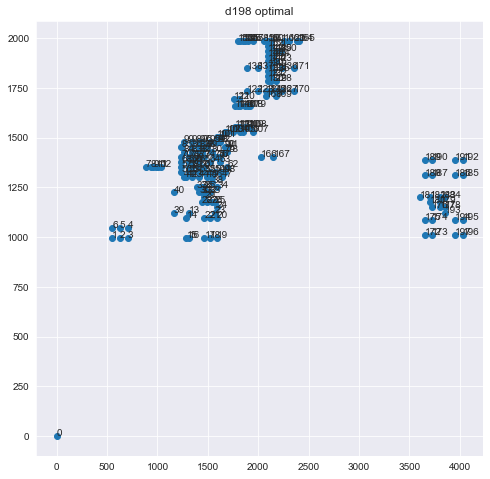

In [2]:
# Creating a TSP instance and printing the information about the instance and plotting the data.
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [3]:
# A class that contains the methods to perform the double bridge perturbation and to compute
# the difference in cost between the edges that will be removed by the double bridge perturbation
# and the edges that will be added by the double bridge perturbation.
class DoubleBridge:

  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    """
    It computes the difference between the cost of the edges that will be added by the double bridge perturbation and
    the cost of the edges that will be removed by the double bridge perturbation.
    :param solution: The solution to be perturbed.
    :param a:        The first index of the first bridge.
    :param b:        The first city of the first bridge.
    :param c:        The index of the first city in the first bridge.
    :param d:        The number of cities in the TSP instance.
    :param matrix:   The distance matrix of the problem.
    :return:         The difference between the cost of the edges that will be added by the double bridge perturbation and
                     the cost of the edges that will be removed by the double bridge perturbation.
    """

    # Computing the cost of the edges that will be removed by the double bridge perturbation
    to_remove = matrix[solution[a - 1], solution[a]] + \
                matrix[solution[b - 1], solution[b]] + \
                matrix[solution[c - 1], solution[c]] + \
                matrix[solution[d - 1], solution[d]]

    # Computing the cost of the edges that will be added by the double bridge perturbation
    to_add = matrix[solution[a], solution[c - 1]] + \
             matrix[solution[b], solution[d - 1]] + \
             matrix[solution[c], solution[a - 1]] + \
             matrix[solution[d], solution[b - 1]]

    # Computing the difference between the cost of the edges that will be added and removed by the double bridge perturbation
    gain = to_add - to_remove

    return gain

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    """
    Given a solution, the cost of that solution, and the cost matrix, return a new solution that is a random perturbation of the original solution,
    by randomly selecting 4 points in the solution, and then swaps the order of the points between the 4 points.
    :param solution:    The current solution, that is a list of the indices of the cities in the order they are visited.
    :param actual_cost: The cost of the current solution.
    :param matrix:      The matrix of distances between cities.
    :return:            The new solution and the new cost.
    """
    # Randomly selecting 4 points in the solution, and then swapping the order of the points between the 4 points
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4, replace=False))

    # Defining the segments of the solution ABCD
    B = solution[a:b]
    C = solution[b:c]
    D = solution[c:d]
    A = np.concatenate((solution[d:], solution[:a]))

    # Calculating the difference in cost between the current solution and the new solution
    gain = DoubleBridge.difference_cost(solution, a, b, c, d, matrix)

    # Defining the segments of the new solution ADCB
    new_solution = np.concatenate((A, D, C, B))

    # Adding the actual cost and the gain to get the new cost
    new_cost = actual_cost + gain

    return new_solution, new_cost

In [4]:
# Example of perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 7.44274295682761
[10 11  8  9  6  7  0  1  2  3  4  5] 7.092387094432593


Given ABCD = [  0  1  2  3  4  5  6  7  8  9 10 11]
and   ADCB = [ 10 11  8  9  6  7  0  1  2  3  4  5]

Which are the vertices in the segments A, B, C and D here?
Which are the vertices a, b, c and d?

A is from 10 to 11
B is from 0 to 5
C is from 6 to 7
D is from 8 to 9

a is 0
b is 6
c is 8
d is 10

## Iterated Local Search


Here you need to implement the three variants of the ILS we saw in class

To boost the time performances please use the cython class **two_opt_with_candidate**.


In [5]:
def my_local_search(s, c, d_matrix):
  """
  Given a solution, cost of the solution, and the distance matrix, return a new solution with a lower cost.
  :param s:        The solution to be improved (a list of integers, where each integer represents a city).
  :param c:        The cost of the solution.
  :param d_matrix: A matrix of distances between cities.
  :return:         The new solution and the new cost.
  """
  new_solution, new_cost = s, c

  for data in TwoOpt.local_search(s, c, d_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data

  return new_solution, new_cost


# This class implements the Iterated Local Search (ILS) algorithm for the Better problem
class ILSBetter:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better
    # Calling the local search function and passing the solution, actual cost and matrix as parameters
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    # You don't need to keep track separately of the best solution and costs so far since are the same of s_star, s_star_cost
    # best_solution, best_cost = s_star, s_star_cost
    calls = 1

    # Append to the list the cost of the solution obtained after the local search
    cost_sol_better.append(s_star_cost)

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # Append to the list the cost of the solution obtained after the local search
      cost_sol_better.append(s_star_prime_cost)

      # implement acceptance criterion
      if s_star_prime_cost < s_star_cost:
        s_star, s_star_cost = s_star_prime, s_star_prime_cost
        # Update the best solution
        # best_solution, best_cost = s_star, s_star_cost

      yield s_star, s_star_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the Random Walk (RW) problem
class ILSRw:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_RW

    # Using the local search algorithm to find a better solution
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    # Keep track separately of the best solution and costs so far
    best_solution, best_cost = s_star, s_star_cost
    calls = 1

    # Append to the list the cost of the solution obtained after the local search
    cost_sol_RW.append(s_star_cost)

    while True:
      # Implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # Append to the list the cost of the solution obtained after the local search
      cost_sol_RW.append(s_star_prime_cost)

      # Implement acceptance criterion
      # Since the perturbation is always applied to the most recently visited local optimum, irrespective of its cost, we updated it
      s_star, s_star_cost = s_star_prime, s_star_prime_cost

      # However, the best solution is updated only if is really the best
      if s_star_prime_cost < best_cost:
        best_solution, best_cost = s_star_prime, s_star_prime_cost

      yield best_solution, best_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the
# Large Step Markov Chain (LSMC) problem
class ILSLsmc:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix,
    return the new solution and the new actual cost.
    It's a simulated annealing algorithm that uses a local search as a perturbation function.
    :param s0:       The solution to be perturbed (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or a 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better

    # Using the local search algorithm to find a better solution.
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    # Keep track separately of the best solution and costs so far
    best_solution, best_cost = s_star, s_star_cost
    calls = 1

    # Append to the list the cost of the solution obtained after the local search
    cost_sol_LSMC.append(s_star_cost)

    # Setting initial temperature such that acceptance probability is close to 1.
    temperature = np.abs(s_star_cost - s0_cost) * 100
    decrease = 0.95

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # Append to the list the cost of the solution obtained after the local search
      cost_sol_LSMC.append(s_star_prime_cost)

      # implement acceptance criterion
      if ILSLsmc.acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
        s_star, s_star_cost = s_star_prime, s_star_prime_cost

      # Update the best solution only if is really the best
      if s_star_prime_cost < best_cost:
        best_solution, best_cost = s_star_prime, s_star_prime_cost

      temperature *= decrease
      yield best_solution, best_cost, calls, False

  @staticmethod
  def acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
    """
    If the new cost is better than the best cost, accept it, otherwise accept it
    with a probability that is proportional to the difference between the new cost and the best cost (the probability decreases as the temperature decreases).
    :param s_star_cost:       The cost of the best solution found so far.
    :param s_star_prime_cost: The cost of the new solution.
    :param temperature:       The current temperature of the system, a parameter that controls the probability of accepting a worse solution.
    :return:                  A boolean value.
    """

    if s_star_prime_cost < s_star_cost:
      return True
    else:
      alpha = np.random.rand(1)
      prob = np.exp((s_star_cost - s_star_prime_cost) / temperature)

      if alpha <= prob:
        return True
      else:
        return False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task! 

In [6]:
seeds = [0, 123, 333]
time_to_solve = 180  # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

# Creating a dictionary with the names of the instances as keys and an empty dictionary as values.
names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]

# Creating a list of initializers and a list of functions that will be used to initialize the weights.
initializers = ["random"]
init_functions = [Random_Initializer.random_method]

# Creating a list of strings and a list of functions.
improvements = ["ILS-Better", "ILS-RW", "ILS-LSMC"]
improve_functions = [ILSBetter.solve, ILSRw.solve, ILSLsmc.solve]

results = []
index = []
samples = {name: {improve: {seed: [] for seed in seeds} for improve in improvements} for name in names_instances}

# Running the solver for each instance, for each improvement method, for each initializer, for each seed.
for s_ in seeds:
  collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve][s_] = np.round(np.abs(np.array(collectors[j]) - instance.best_sol) / instance.best_sol * 100, 2)
        if j == 0:
          cost_sol_better = []
        elif j == 1:
          cost_sol_RW = []
        else:
          cost_sol_LSMC = []

index = pd.MultiIndex.from_tuples(index, names=['problem', 'optimal length', 'method', 'seed'])

df = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"])
df

,,,,tour length,gap,time to solve,calls local search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-Better",0,15848.0,0.43,180.085,676
pr439.tsp,107217.0,"initialized with random, improved with ILS-Better",0,109774.0,2.38,180.592,124
u1060.tsp,224094.0,"initialized with random, improved with ILS-Better",0,245950.0,9.75,185.409,18
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16109.0,2.08,180.143,698
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,112528.0,4.95,181.717,117
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,245258.0,9.44,189.495,20
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,15812.0,0.20,180.059,713
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,111635.0,4.12,181.211,124
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,245369.0,9.49,185.125,16


In [7]:
def statistic_creator(dataframe):
  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', None)
  pd.set_option('display.max_colwidth', None)

  df = dataframe

  #Statistics for local search calls
  result = []
  index = []

  lowest_df = pd.DataFrame()
  for method in improvements:
    for problem in names_instances:
      ILS_df = df.filter(like = method, axis=0)
      ILS_Res_df = ILS_df.filter(like = problem, axis=0)
      ILS_LSC_mean_df = round(ILS_Res_df["calls local search"].mean(),2)
      ILS_LSC_std_df = round(ILS_Res_df["calls local search"].std(),2)
      ILS_gap_mean_df = round(ILS_Res_df["gap"].mean(),3)
      ILS_gap_std_df = round(ILS_Res_df["gap"].std(),3)
      if method == 'ILS-Better':
        ILS_problem_df = df.filter(like = problem, axis=0)
        lowest_df = pd.concat([lowest_df, ILS_problem_df[ILS_problem_df.gap == ILS_problem_df.gap.min()]])
      result.append([problem, ILS_gap_mean_df, ILS_LSC_mean_df, ILS_gap_std_df, ILS_LSC_std_df])
      index.append(method)

  res_df = pd.DataFrame(result, index=index, columns=["Problem", "Mean Gap", "Mean Calls", "STD Gap", "STD Calls"])
  display(res_df)

  lowest_df.rename(columns={'method': 'initialized with random, method'}, inplace=True)
  display(lowest_df)

statistic_creator(dataframe = df)

,Problem,Mean Gap,Mean Calls,STD Gap,STD Calls
ILS-Better,d198.tsp,0.757,706.67,0.482,26.56
ILS-Better,pr439.tsp,2.837,126.33,0.418,4.93
ILS-Better,u1060.tsp,10.017,18.00,1.017,0.00
ILS-RW,d198.tsp,1.750,699.00,0.312,4.58
ILS-RW,pr439.tsp,5.530,121.67,0.503,4.16
ILS-RW,u1060.tsp,9.657,18.67,0.367,2.31
ILS-LSMC,d198.tsp,0.370,714.00,0.170,5.57
ILS-LSMC,pr439.tsp,4.637,124.00,1.201,3.00
ILS-LSMC,u1060.tsp,9.737,17.00,0.453,1.00


,,,,tour length,gap,time to solve,calls local search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,15812.0,0.20,180.059,713
pr439.tsp,107217.0,"initialized with random, improved with ILS-Better",0,109774.0,2.38,180.592,124
u1060.tsp,224094.0,"initialized with random, improved with ILS-Better",123,244615.0,9.16,184.463,18


#### Problem: d198.tsp

In [8]:
df1 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'd198.tsp', axis=0)
df1

tour length  \
problem  optimal length method                                            seed                
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0         15848.0   
                        initialized with random, improved with ILS-RW     0         16109.0   
                        initialized with random, improved with ILS-LSMC   0         15812.0   
                        initialized with random, improved with ILS-Better 123       15864.0   
                        initialized with random, improved with ILS-RW     123       16011.0   
                        initialized with random, improved with ILS-LSMC   123       15866.0   
                        initialized with random, improved with ILS-Better 333       15987.0   
                        initialized with random, improved with ILS-RW     333       16050.0   
                        initialized with random, improved with ILS-LSMC   333       15839.0   

                                                                                 gap  \
problem  optimal length method                                            seed         
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0     0.43   
                        initialized with random, improved with ILS-RW     0     2.08   
                        initialized with random, improved with ILS-LSMC   0     0.20   
                        initialized with random, improved with ILS-Better 123   0.53   
                        initialized with random, improved with ILS-RW     123   1.46   
                        initialized with random, improved with ILS-LSMC   123   0.54   
                        initialized with random, improved with ILS-Better 333   1.31   
                        initialized with random, improved with ILS-RW     333   1.71   
                        initialized with random, improved with ILS-LSMC   333   0.37   

                                                                                time to solve  \
problem  optimal length method                                            seed                  
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0           180.085   
                        initialized with random, improved with ILS-RW     0           180.143   
                        initialized with random, improved with ILS-LSMC   0           180.059   
                        initialized with random, improved with ILS-Better 123         180.130   
                        initialized with random, improved with ILS-RW     123         180.210   
                        initialized with random, improved with ILS-LSMC   123         180.231   
                        initialized with random, improved with ILS-Better 333         180.056   
                        initialized with random, improved with ILS-RW     333         180.146   
                        initialized with random, improved with ILS-LSMC   333         180.041   

                                                                                calls local search  
problem  optimal length method                                            seed                      
d198.tsp 15780.0        initialized with random, improved with ILS-Better 0                    676  
                        initialized with random, improved with ILS-RW     0                    698  
                        initialized with random, improved with ILS-LSMC   0                    713  
                        initialized with random, improved with ILS-Better 123                  722  
                        initialized with random, improved with ILS-RW     123                  704  
                        initialized with random, improved with ILS-LSMC   123                  709  
                        initialized with random, improved with ILS-Better 333                  722  
                        initialized with random, improved with ILS-RW     333           

In [9]:
df1.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",15848.0,15899.666667,76.054805
"initialized with random, improved with ILS-LSMC",15812.0,15839.000000,27.000000
"initialized with random, improved with ILS-RW",16011.0,16056.666667,49.338964


In [10]:
df1.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",0.43,0.756667,0.481802
"initialized with random, improved with ILS-LSMC",0.20,0.370000,0.170000
"initialized with random, improved with ILS-RW",1.46,1.750000,0.311929


In [11]:
df1.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",676,706.666667,26.558112
"initialized with random, improved with ILS-LSMC",709,714.000000,5.567764
"initialized with random, improved with ILS-RW",695,699.000000,4.582576


#### Problem: pr439.tsp

In [12]:
df2 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'pr439.tsp', axis=0)
df2

tour length  \
problem   optimal length method                                            seed                
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0        109774.0   
                         initialized with random, improved with ILS-RW     0        112528.0   
                         initialized with random, improved with ILS-LSMC   0        111635.0   
                         initialized with random, improved with ILS-Better 123      110651.0   
                         initialized with random, improved with ILS-RW     123      113427.0   
                         initialized with random, improved with ILS-LSMC   123      111275.0   
                         initialized with random, improved with ILS-Better 333      110363.0   
                         initialized with random, improved with ILS-RW     333      113485.0   
                         initialized with random, improved with ILS-LSMC   333      113661.0   

                                                                                  gap  \
problem   optimal length method                                            seed         
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0     2.38   
                         initialized with random, improved with ILS-RW     0     4.95   
                         initialized with random, improved with ILS-LSMC   0     4.12   
                         initialized with random, improved with ILS-Better 123   3.20   
                         initialized with random, improved with ILS-RW     123   5.79   
                         initialized with random, improved with ILS-LSMC   123   3.78   
                         initialized with random, improved with ILS-Better 333   2.93   
                         initialized with random, improved with ILS-RW     333   5.85   
                         initialized with random, improved with ILS-LSMC   333   6.01   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0           180.592   
                         initialized with random, improved with ILS-RW     0           181.717   
                         initialized with random, improved with ILS-LSMC   0           181.211   
                         initialized with random, improved with ILS-Better 123         180.750   
                         initialized with random, improved with ILS-RW     123         181.187   
                         initialized with random, improved with ILS-LSMC   123         180.753   
                         initialized with random, improved with ILS-Better 333         180.489   
                         initialized with random, improved with ILS-RW     333         181.409   
                         initialized with random, improved with ILS-LSMC   333         180.112   

                                                                                 calls local search  
problem   optimal length method                                            seed                      
pr439.tsp 107217.0       initialized with random, improved with ILS-Better 0                    124  
                         initialized with random, improved with ILS-RW     0                    117  
                         initialized with random, improved with ILS-LSMC   0                    124  
                         initialized with random, improved with ILS-Better 123                  132  
                         initialized with random, improved with ILS-RW     123                  123  
                         initialized with random, improved with ILS-LSMC   123                  127  
                         initialized with random, improved with ILS-Better 333                  123  
                         initialized with rando

In [13]:
df2.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",109774.0,110262.666667,447.026099
"initialized with random, improved with ILS-LSMC",111275.0,112190.333333,1286.291310
"initialized with random, improved with ILS-RW",112528.0,113146.666667,536.565311


In [14]:
df2.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",2.38,2.836667,0.417892
"initialized with random, improved with ILS-LSMC",3.78,4.636667,1.201430
"initialized with random, improved with ILS-RW",4.95,5.530000,0.503190


In [15]:
df2.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",123,126.333333,4.932883
"initialized with random, improved with ILS-LSMC",121,124.000000,3.000000
"initialized with random, improved with ILS-RW",117,121.666667,4.163332


#### Problem: u1060.tsp

In [16]:
df3 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'u1060.tsp', axis=0)
df3

tour length  \
problem   optimal length method                                            seed                
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0        245950.0   
                         initialized with random, improved with ILS-RW     0        245258.0   
                         initialized with random, improved with ILS-LSMC   0        245369.0   
                         initialized with random, improved with ILS-Better 123      244615.0   
                         initialized with random, improved with ILS-RW     123      246672.0   
                         initialized with random, improved with ILS-LSMC   123      245302.0   
                         initialized with random, improved with ILS-Better 333      249068.0   
                         initialized with random, improved with ILS-RW     333      245274.0   
                         initialized with random, improved with ILS-LSMC   333      247081.0   

                                                                                   gap  \
problem   optimal length method                                            seed          
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0      9.75   
                         initialized with random, improved with ILS-RW     0      9.44   
                         initialized with random, improved with ILS-LSMC   0      9.49   
                         initialized with random, improved with ILS-Better 123    9.16   
                         initialized with random, improved with ILS-RW     123   10.08   
                         initialized with random, improved with ILS-LSMC   123    9.46   
                         initialized with random, improved with ILS-Better 333   11.14   
                         initialized with random, improved with ILS-RW     333    9.45   
                         initialized with random, improved with ILS-LSMC   333   10.26   

                                                                                 time to solve  \
problem   optimal length method                                            seed                  
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0           185.409   
                         initialized with random, improved with ILS-RW     0           189.495   
                         initialized with random, improved with ILS-LSMC   0           185.125   
                         initialized with random, improved with ILS-Better 123         184.463   
                         initialized with random, improved with ILS-RW     123         182.139   
                         initialized with random, improved with ILS-LSMC   123         186.227   
                         initialized with random, improved with ILS-Better 333         180.682   
                         initialized with random, improved with ILS-RW     333         194.195   
                         initialized with random, improved with ILS-LSMC   333         180.826   

                                                                                 calls local search  
problem   optimal length method                                            seed                      
u1060.tsp 224094.0       initialized with random, improved with ILS-Better 0                     18  
                         initialized with random, improved with ILS-RW     0                     20  
                         initialized with random, improved with ILS-LSMC   0                     16  
                         initialized with random, improved with ILS-Better 123                   18  
                         initialized with random, improved with ILS-RW     123                   16  
                         initialized with random, improved with ILS-LSMC   123                   18  
                         initialized with random, improved with ILS-Better 333                   18  
                         initialized

In [17]:
df3.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",244615.0,246544.333333,2285.219100
"initialized with random, improved with ILS-LSMC",245302.0,245917.333333,1008.321543
"initialized with random, improved with ILS-RW",245258.0,245734.666667,811.793898


In [18]:
df3.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",9.16,10.016667,1.016579
"initialized with random, improved with ILS-LSMC",9.46,9.736667,0.453468
"initialized with random, improved with ILS-RW",9.44,9.656667,0.366652


In [19]:
df3.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-Better",18,18.000000,0.000000
"initialized with random, improved with ILS-LSMC",16,17.000000,1.000000
"initialized with random, improved with ILS-RW",16,18.666667,2.309401


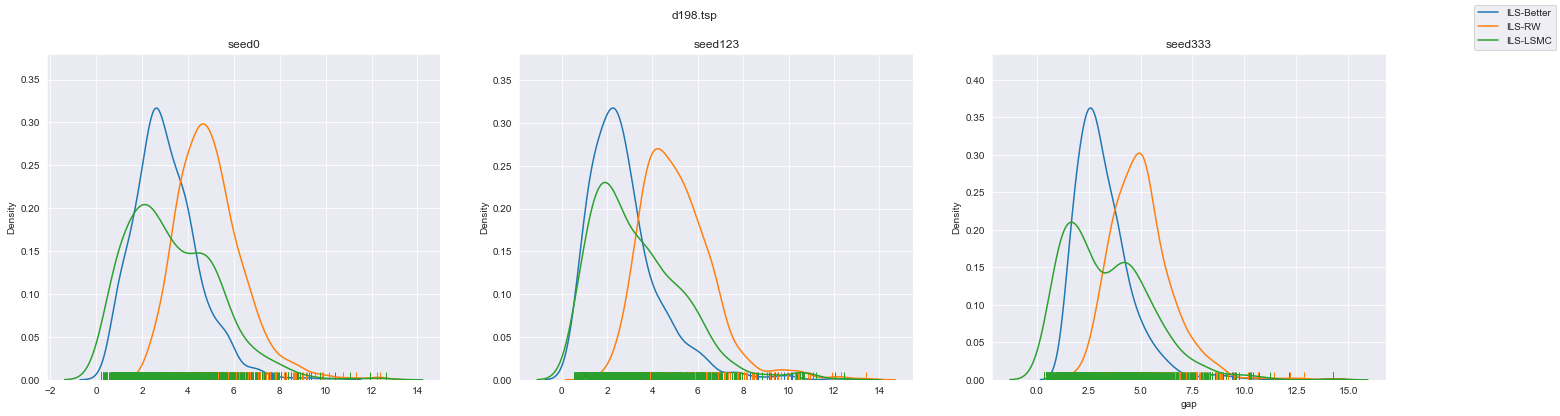

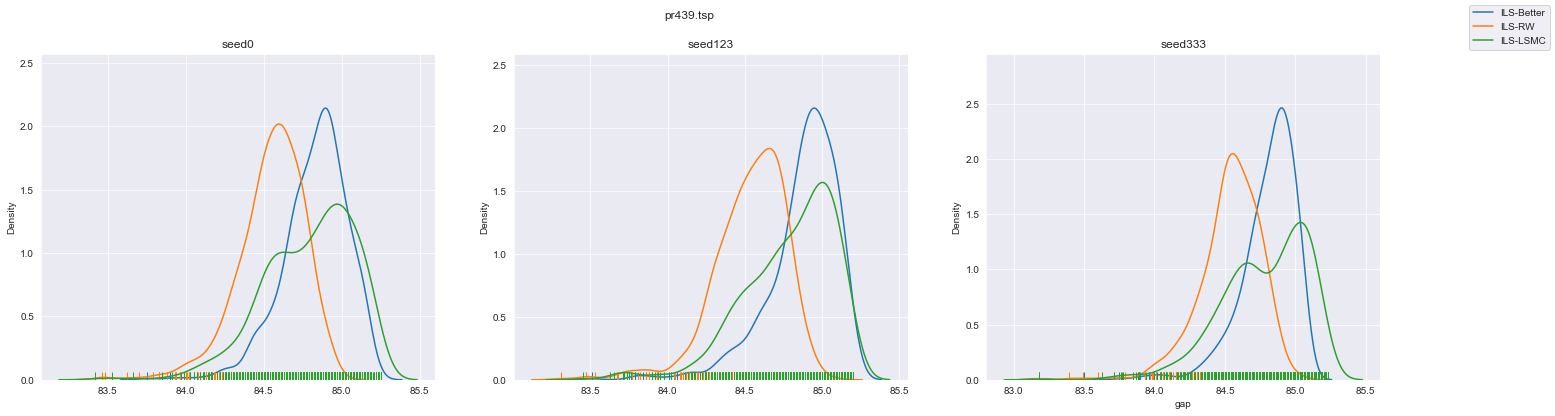

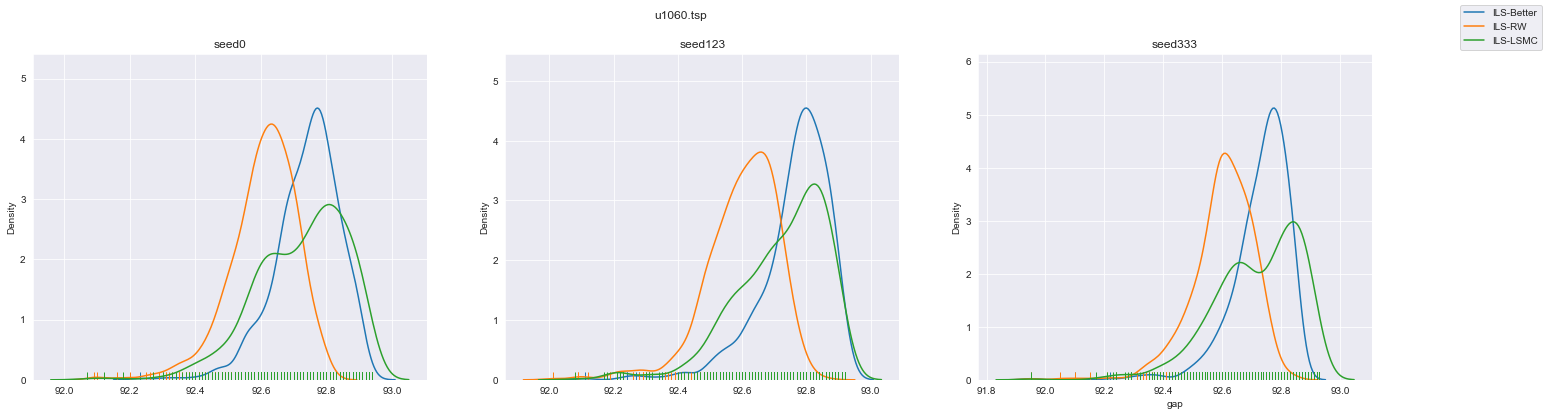

In [20]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    for improve in improvements:
      for idx, s in enumerate(seeds):
        sns.distplot(samples[instance][improve][s], rug=True, hist=False,  ax=axes[idx]).set_title('seed' + str(s))

    fig.legend(handles=axes[0].lines, labels=improvements)
    fig.suptitle(instance)
    plt.xlabel('gap')
    plt.show()